<a href="https://colab.research.google.com/github/parsakzr/ytu-bitirme/blob/main/Bitirme_FreeMode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets accelerate trl wandb einops
!pip install -q -U bitsandbytes

!pip -q install git+https://github.com/huggingface/peft.git

# !pip install -q trl xformers wandb datasets einops sentencepiece

In [42]:
from huggingface_hub import notebook_login

notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Dataset
The dataset is [CodeAlpaca-20k](https://github.com/sahil280114/codealpaca)

In [1]:
from datasets import load_dataset


dataset_id = "sahil2801/CodeAlpaca-20k"
dataset = load_dataset(dataset_id, split="train")

print(dataset)

Dataset({
    features: ['input', 'instruction', 'output'],
    num_rows: 20022
})


## Dataset preperation:


The prompt format is as follows:

```
Below is an instruction that describes a task. Write an output that appropriately completes the request.
### Instruction: {{instruction}}
### Input: {{input(optional)}}
### Output:
<code>
```

In [6]:
from trl import DataCollatorForCompletionOnlyLM
# from transformers import DataCollatorForLanguageModeling

# # ref: https://huggingface.co/docs/trl/main/en/sft_trainer
# Same concept as code below but using DataCollatorForCompletionOnlyLM
def formatting_prompts_func(example, lang='py'):
    output_texts = []
    for i in range(len(example['instruction'])):
        text = f"Below is an instruction that describes a task. Write an output that appropriately completes the request.\n\n"
        text += f"### Instruction: {example['instruction'][i]}\n\n### Input: {example['input'][i]}\n\n### Output:\n\'\'\'{lang}\n{example['output'][i]}\n\'\'\'"
        output_texts.append(text)
    return output_texts

response_template = "\n### Output:\n"
# completionCollator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)
collator = DataCollatorForCompletionOnlyLM(response_template=response_template, tokenizer=tokenizer)

In [7]:
def prompt_function(example):
  '''
  alpaca (used by e.g. gpt4-x-vicuna)

  ### Instruction: {{prompt}}
  ### Input: {{input}}
  ### Response:{{gen}}
  '''

  instruction = example['instruction']
  inputs = example['input']
  code = example['output']
  lang = 'py' # TODO: make this as a column in the dataset
  
  prompt = f"Below is an instruction that describes a task. Write an output that appropriately completes the request.\n\n"
  prompt += f"### Instruction: {instruction}\n\n### Input: {inputs}\n\n### Output:\n\'\'\'{lang}\n{code}\n\'\'\'"

  return prompt

## Loading the model and tokenizer

In [3]:
import transformers
import torch
from transformers import AutoModelForCausalLM
from transformers import BitsAndBytesConfig


model_id = "Salesforce/codegen-350M-mono"


model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # device_map='auto', # 'cpu' or 'cuda'(or 'mps' for mac)
    use_cache=False,
    # attn_implementation="flash_attention_2",
)

# Load the model, and quantize it in 4bit
if transformers.is_bitsandbytes_available():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )
    model.config.quantization_config=bnb_config


In [4]:
from transformers import AutoTokenizer
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"  # 'left' allows batched inference

In [11]:
def generate_response(prompt, model, tokenizer):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  # encoded_input = encoded_input.to('mps')

  generated_ids = model.generate(**encoded_input,
                                 max_new_tokens=512,
                                 do_sample=True,
                                 pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0].replace(prompt, "")

Let's try out the model on a few examples:

In [ ]:
prompt = prompt_function(dataset[4])
print('----- Prompt -----')
print(prompt)
print('----- Response -----')
print(generate_response(prompt, model, tokenizer))

In [ ]:
'''The output prettified:
# Test Your Code

def replace(self, *args):
    return "".join([char*count for (char, count) in args for char in self])<|endoftext|>

'''

### Tokenization

In [7]:
def tokenize_function(example):
  prompt = prompt_function(example)
  # example['prompt'] = prompt
  return tokenizer(prompt, truncation=True, return_tensors="pt", add_special_tokens=True) # , padding=False,

dataset_tokenized = dataset.map(tokenize_function, remove_columns=dataset.column_names) # , batched=True, num_proc=4
print(dataset_tokenized)

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 20022
})


In [ ]:
dataset_tokenized = dataset_tokenized.set_format('torch')

Max token lenght: 1353


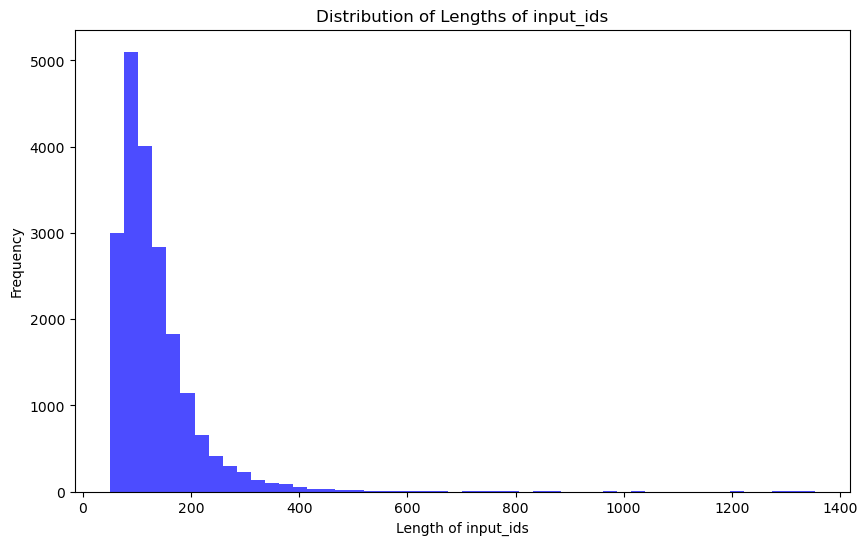

In [8]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_dataset):
    lengths = [len(x['input_ids'][0]) for x in tokenized_dataset] # x['input_ids'][0] because return_tensors='pt', so it's a list [[**ids]]
    print(f'Max token lenght: {max(lengths)}')

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    # plt.xlim([0, 800])
    plt.show()


plot_data_lengths(dataset_tokenized)

In [ ]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
# from datasets import *

# Dynamic Padding; Will be used as collation_fn parameter in Dataloader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



# Split the dataset into a training and evaluation dataset
dataset_train_test_split = dataset_tokenized.train_test_split(test_size=0.2)

# Extract the training and evaluation datasets
dataset_train = dataset_train_test_split['train']
dataset_eval = dataset_train_test_split['test']

# print(type(_train))

train_dataloader = DataLoader(
    dataset_train, shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    dataset_eval, batch_size=8, collate_fn=data_collator
)

In [ ]:
# Inspect batch health
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}


## Fine-tuning ⚡⚙️

### Peft config.

In [9]:
# print model for trainable layers
print(model)

CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)


In [10]:
from peft import LoraConfig, get_peft_model
from peft import prepare_model_for_kbit_training

# TODO is it necessary?
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

#Lora config
LORA_R = 64 # 4
LORA_ALPHA = 16
LORA_DROPOUT = 0.05 # similar to regularisation

peft_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
    # QLoRA paper recommended to consider ALL linear layers.
    target_modules=[
        "qkv_proj",
        "out_proj",
        "fc_in",
        "fc_out",
        "lm_head",
    ]
)

model = get_peft_model(model, peft_config)

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [11]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 24313856 || all params: 381026304 || trainable%: 6.381148950808393


In [12]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): CodeGenForCausalLM(
      (transformer): CodeGenModel(
        (wte): Embedding(51200, 1024)
        (drop): Dropout(p=0.0, inplace=False)
        (h): ModuleList(
          (0-19): 20 x CodeGenBlock(
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attn): CodeGenAttention(
              (attn_dropout): Dropout(p=0.0, inplace=False)
              (resid_dropout): Dropout(p=0.0, inplace=False)
              (qkv_proj): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=3072, bias=Fal

### Trainer Config

In [ ]:
## TODO: uncomment if SFTTrainer didnt work
# from transformers import Trainer, TrainingArguments

# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         # forward pass
#         outputs = model(**inputs, labels=inputs["input_ids"])
#         logits = outputs.get("logits")
#         # compute custom loss (suppose one has 3 labels with different weights)
#         loss = outputs.loss
#         return (loss, outputs) if return_outputs else loss

# The block under TrainingArguments

# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=dataset_train,
#     eval_dataset=dataset_eval,
#     data_collator=data_collator,
#     tokenizer=tokenizer,
# )


In [8]:
from transformers import TrainingArguments

OUTPUT_DIR = 'lora-finetuned' + model_id.split("/")[-1] + '-temp3'
# OPTIM = "paged_adamw_32bit"

''' The code below is before new training args on 2023-12-25
# Settings for T4 (A100)
MICRO_BATCH_SIZE = 2 # 4? for A100
BATCH_SIZE = 128
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE # or just 4
EPOCHS = 1
LEARNING_RATE = 2e-4 #2e-5
CUTOFF_LEN = 256

WARMUP_RATIO = 0.03
MAX_STEPS = 100 # 300
MAX_GRAD_NORM = 0.3
LR_SCHEDULER_TYPE = "constant"
SAVE_STEPS = 50
LOGGING_STEPS = 5


training_args = TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    num_train_epochs=EPOCHS,
    # optim=OPTIM,
    warmup_ratio=WARMUP_RATIO, # warmup_steps=100,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    # fp16=True,
    # evaluation_strategy = "steps",
    save_steps= SAVE_STEPS, # save_total_limit=3,
    output_dir=OUTPUT_DIR,
    report_to='tensorboard',
    logging_steps=LOGGING_STEPS,
    logging_dir=OUTPUT_DIR+'/logs',
    # load_best_model_at_end=True, # requires evaluation strategy and save strategy to match
)
'''

# MICRO_BATCH_SIZE = 2 # 4? for A100
BATCH_SIZE = 4
# GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE # or just 4
MAX_STEPS = 2000 # 300
EPOCHS = 1
LEARNING_RATE = 2e-4 #2e-5
CUTOFF_LEN = 256

WARMUP_RATIO = 0.03
LR_SCHEDULER_TYPE = "constant"
SAVE_STEPS = 100
LOGGING_STEPS = 5
training_args = TrainingArguments(
    per_device_train_batch_size=BATCH_SIZE,
    max_steps=MAX_STEPS,
    num_train_epochs=EPOCHS,
    # optim=OPTIM,
    warmup_ratio=WARMUP_RATIO, # warmup_steps=100,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    # fp16=True,
    # evaluation_strategy = "steps",
    save_steps= SAVE_STEPS, # save_total_limit=3,
    output_dir=OUTPUT_DIR,
    report_to='tensorboard',
    logging_steps=LOGGING_STEPS,
    logging_dir=OUTPUT_DIR+'/logs',
)

### Training

In [14]:
from trl import SFTTrainer

MAX_SEQ_LENGTH = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    # dataset_text_field="text", # messy error
    formatting_func=prompt_function, # description above, data preparation
    # data_collator=collator,
    packing=True,
    max_seq_length=MAX_SEQ_LENGTH,
    tokenizer=tokenizer,
    args=training_args,
)

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(
/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/trl/trainer/utils.py:548: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(
/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:267: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [15]:
trainer.train()
trainer.save_model()

  0%|          | 0/2000 [00:00<?, ?it/s]

You're using a CodeGenTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.3874, 'learning_rate': 0.0002, 'epoch': 0.0}
{'loss': 1.1003, 'learning_rate': 0.0002, 'epoch': 0.0}
{'loss': 1.1256, 'learning_rate': 0.0002, 'epoch': 0.0}
{'loss': 0.891, 'learning_rate': 0.0002, 'epoch': 0.0}
{'loss': 0.8712, 'learning_rate': 0.0002, 'epoch': 0.0}
{'loss': 0.8799, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 0.757, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 0.9248, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 0.927, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 0.8272, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 0.7653, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 0.7208, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 0.7615, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 0.7185, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 0.7238, 'learning_rate': 0.0002, 'epoch': 0.01}
{'loss': 0.7785, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.7342, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.7351, 'learning_rate': 0.000

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.7874, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.7827, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.6379, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.7042, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.7636, 'learning_rate': 0.0002, 'epoch': 0.02}
{'loss': 0.6931, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 0.7123, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 0.661, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 0.7659, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 0.7331, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 0.766, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 0.6923, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 0.7168, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 0.6813, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 0.6476, 'learning_rate': 0.0002, 'epoch': 0.03}
{'loss': 0.6684, 'learning_rate': 0.0002, 'epoch': 0.04}
{'loss': 0.6057, 'learning_rate': 0.0002, 'epoch': 0.04}
{'loss': 0.7174, 'learning_rate':

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.7258, 'learning_rate': 0.0002, 'epoch': 0.04}
{'loss': 0.6282, 'learning_rate': 0.0002, 'epoch': 0.04}
{'loss': 0.7351, 'learning_rate': 0.0002, 'epoch': 0.04}
{'loss': 0.6435, 'learning_rate': 0.0002, 'epoch': 0.04}
{'loss': 0.7425, 'learning_rate': 0.0002, 'epoch': 0.04}
{'loss': 0.7853, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.6903, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.7167, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.7026, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.7058, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.6904, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.6571, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.7631, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.7322, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.6781, 'learning_rate': 0.0002, 'epoch': 0.05}
{'loss': 0.7159, 'learning_rate': 0.0002, 'epoch': 0.06}
{'loss': 0.7629, 'learning_rate': 0.0002, 'epoch': 0.06}
{'loss': 0.7118, 'learning_rate

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.7662, 'learning_rate': 0.0002, 'epoch': 0.06}
{'loss': 0.6489, 'learning_rate': 0.0002, 'epoch': 0.06}
{'loss': 0.6753, 'learning_rate': 0.0002, 'epoch': 0.06}
{'loss': 0.6588, 'learning_rate': 0.0002, 'epoch': 0.06}
{'loss': 0.6767, 'learning_rate': 0.0002, 'epoch': 0.06}
{'loss': 0.632, 'learning_rate': 0.0002, 'epoch': 0.07}
{'loss': 0.83, 'learning_rate': 0.0002, 'epoch': 0.07}
{'loss': 0.7051, 'learning_rate': 0.0002, 'epoch': 0.07}
{'loss': 0.7047, 'learning_rate': 0.0002, 'epoch': 0.07}
{'loss': 0.7854, 'learning_rate': 0.0002, 'epoch': 0.07}
{'loss': 0.745, 'learning_rate': 0.0002, 'epoch': 0.07}
{'loss': 0.7008, 'learning_rate': 0.0002, 'epoch': 0.07}
{'loss': 0.7291, 'learning_rate': 0.0002, 'epoch': 0.07}
{'loss': 0.6627, 'learning_rate': 0.0002, 'epoch': 0.07}
{'loss': 0.7252, 'learning_rate': 0.0002, 'epoch': 0.07}
{'loss': 0.6881, 'learning_rate': 0.0002, 'epoch': 0.08}
{'loss': 0.7127, 'learning_rate': 0.0002, 'epoch': 0.08}
{'loss': 0.7867, 'learning_rate': 0

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.7003, 'learning_rate': 0.0002, 'epoch': 0.08}
{'loss': 0.7453, 'learning_rate': 0.0002, 'epoch': 0.08}
{'loss': 0.7196, 'learning_rate': 0.0002, 'epoch': 0.08}
{'loss': 0.6518, 'learning_rate': 0.0002, 'epoch': 0.08}
{'loss': 0.6921, 'learning_rate': 0.0002, 'epoch': 0.08}
{'loss': 0.7462, 'learning_rate': 0.0002, 'epoch': 0.09}
{'loss': 0.7088, 'learning_rate': 0.0002, 'epoch': 0.09}
{'loss': 0.6825, 'learning_rate': 0.0002, 'epoch': 0.09}
{'loss': 0.7138, 'learning_rate': 0.0002, 'epoch': 0.09}
{'loss': 0.7274, 'learning_rate': 0.0002, 'epoch': 0.09}
{'loss': 0.7096, 'learning_rate': 0.0002, 'epoch': 0.09}
{'loss': 0.7276, 'learning_rate': 0.0002, 'epoch': 0.09}
{'loss': 0.7261, 'learning_rate': 0.0002, 'epoch': 0.09}
{'loss': 0.7223, 'learning_rate': 0.0002, 'epoch': 0.09}
{'loss': 0.749, 'learning_rate': 0.0002, 'epoch': 0.09}
{'loss': 0.7796, 'learning_rate': 0.0002, 'epoch': 0.1}
{'loss': 0.846, 'learning_rate': 0.0002, 'epoch': 0.1}
{'loss': 0.7323, 'learning_rate': 0

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.6862, 'learning_rate': 0.0002, 'epoch': 0.1}
{'loss': 0.6894, 'learning_rate': 0.0002, 'epoch': 0.1}
{'loss': 0.6511, 'learning_rate': 0.0002, 'epoch': 0.1}
{'loss': 0.7058, 'learning_rate': 0.0002, 'epoch': 0.1}
{'loss': 0.6584, 'learning_rate': 0.0002, 'epoch': 0.1}
{'loss': 0.7358, 'learning_rate': 0.0002, 'epoch': 0.11}
{'loss': 0.6574, 'learning_rate': 0.0002, 'epoch': 0.11}
{'loss': 0.7604, 'learning_rate': 0.0002, 'epoch': 0.11}
{'loss': 0.7156, 'learning_rate': 0.0002, 'epoch': 0.11}
{'loss': 0.734, 'learning_rate': 0.0002, 'epoch': 0.11}
{'loss': 0.6763, 'learning_rate': 0.0002, 'epoch': 0.11}
{'loss': 0.7182, 'learning_rate': 0.0002, 'epoch': 0.11}
{'loss': 0.7652, 'learning_rate': 0.0002, 'epoch': 0.11}
{'loss': 0.7107, 'learning_rate': 0.0002, 'epoch': 0.11}
{'loss': 0.7513, 'learning_rate': 0.0002, 'epoch': 0.11}
{'loss': 0.6871, 'learning_rate': 0.0002, 'epoch': 0.12}
{'loss': 0.8397, 'learning_rate': 0.0002, 'epoch': 0.12}
{'loss': 0.7386, 'learning_rate': 0.0

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.7205, 'learning_rate': 0.0002, 'epoch': 0.12}
{'loss': 0.7022, 'learning_rate': 0.0002, 'epoch': 0.12}
{'loss': 0.7008, 'learning_rate': 0.0002, 'epoch': 0.12}
{'loss': 0.752, 'learning_rate': 0.0002, 'epoch': 0.12}
{'loss': 0.6443, 'learning_rate': 0.0002, 'epoch': 0.12}
{'loss': 0.7708, 'learning_rate': 0.0002, 'epoch': 0.13}
{'loss': 0.7313, 'learning_rate': 0.0002, 'epoch': 0.13}
{'loss': 0.7496, 'learning_rate': 0.0002, 'epoch': 0.13}
{'loss': 0.7455, 'learning_rate': 0.0002, 'epoch': 0.13}
{'loss': 0.7501, 'learning_rate': 0.0002, 'epoch': 0.13}
{'loss': 0.6663, 'learning_rate': 0.0002, 'epoch': 0.13}
{'loss': 0.7334, 'learning_rate': 0.0002, 'epoch': 0.13}
{'loss': 0.7175, 'learning_rate': 0.0002, 'epoch': 0.13}
{'loss': 0.6836, 'learning_rate': 0.0002, 'epoch': 0.13}
{'loss': 0.762, 'learning_rate': 0.0002, 'epoch': 0.13}
{'loss': 0.7112, 'learning_rate': 0.0002, 'epoch': 0.14}
{'loss': 0.6664, 'learning_rate': 0.0002, 'epoch': 0.14}
{'loss': 0.6703, 'learning_rate':

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.7435, 'learning_rate': 0.0002, 'epoch': 0.14}
{'loss': 0.6903, 'learning_rate': 0.0002, 'epoch': 0.14}
{'loss': 0.7309, 'learning_rate': 0.0002, 'epoch': 0.14}
{'loss': 0.7275, 'learning_rate': 0.0002, 'epoch': 0.14}
{'loss': 0.6621, 'learning_rate': 0.0002, 'epoch': 0.14}
{'loss': 0.6495, 'learning_rate': 0.0002, 'epoch': 0.15}
{'loss': 0.6943, 'learning_rate': 0.0002, 'epoch': 0.15}
{'loss': 0.685, 'learning_rate': 0.0002, 'epoch': 0.15}
{'loss': 0.6602, 'learning_rate': 0.0002, 'epoch': 0.15}
{'loss': 0.794, 'learning_rate': 0.0002, 'epoch': 0.15}
{'loss': 0.7068, 'learning_rate': 0.0002, 'epoch': 0.15}
{'loss': 0.7246, 'learning_rate': 0.0002, 'epoch': 0.15}
{'loss': 0.8232, 'learning_rate': 0.0002, 'epoch': 0.15}
{'loss': 0.6725, 'learning_rate': 0.0002, 'epoch': 0.15}
{'loss': 0.7092, 'learning_rate': 0.0002, 'epoch': 0.15}
{'loss': 0.734, 'learning_rate': 0.0002, 'epoch': 0.16}
{'loss': 0.6923, 'learning_rate': 0.0002, 'epoch': 0.16}
{'loss': 0.7201, 'learning_rate': 

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.6728, 'learning_rate': 0.0002, 'epoch': 0.16}
{'loss': 0.7096, 'learning_rate': 0.0002, 'epoch': 0.16}
{'loss': 0.7191, 'learning_rate': 0.0002, 'epoch': 0.16}
{'loss': 0.6887, 'learning_rate': 0.0002, 'epoch': 0.16}
{'loss': 0.6964, 'learning_rate': 0.0002, 'epoch': 0.16}
{'loss': 0.7453, 'learning_rate': 0.0002, 'epoch': 0.17}
{'loss': 0.7536, 'learning_rate': 0.0002, 'epoch': 0.17}
{'loss': 0.7493, 'learning_rate': 0.0002, 'epoch': 0.17}
{'loss': 0.7069, 'learning_rate': 0.0002, 'epoch': 0.17}
{'loss': 0.7243, 'learning_rate': 0.0002, 'epoch': 0.17}
{'loss': 0.6468, 'learning_rate': 0.0002, 'epoch': 0.17}
{'loss': 0.6317, 'learning_rate': 0.0002, 'epoch': 0.17}
{'loss': 0.7055, 'learning_rate': 0.0002, 'epoch': 0.17}
{'loss': 0.7737, 'learning_rate': 0.0002, 'epoch': 0.17}
{'loss': 0.7014, 'learning_rate': 0.0002, 'epoch': 0.17}
{'loss': 0.7389, 'learning_rate': 0.0002, 'epoch': 0.18}
{'loss': 0.6746, 'learning_rate': 0.0002, 'epoch': 0.18}
{'loss': 0.7177, 'learning_rate

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.7174, 'learning_rate': 0.0002, 'epoch': 0.18}
{'loss': 0.7922, 'learning_rate': 0.0002, 'epoch': 0.18}
{'loss': 0.7991, 'learning_rate': 0.0002, 'epoch': 0.18}
{'loss': 0.7612, 'learning_rate': 0.0002, 'epoch': 0.18}
{'loss': 0.6466, 'learning_rate': 0.0002, 'epoch': 0.18}
{'loss': 0.7359, 'learning_rate': 0.0002, 'epoch': 0.19}
{'loss': 0.7626, 'learning_rate': 0.0002, 'epoch': 0.19}
{'loss': 0.7055, 'learning_rate': 0.0002, 'epoch': 0.19}
{'loss': 0.7, 'learning_rate': 0.0002, 'epoch': 0.19}
{'loss': 0.7055, 'learning_rate': 0.0002, 'epoch': 0.19}
{'loss': 0.7602, 'learning_rate': 0.0002, 'epoch': 0.19}
{'loss': 0.6543, 'learning_rate': 0.0002, 'epoch': 0.19}
{'loss': 0.7215, 'learning_rate': 0.0002, 'epoch': 0.19}
{'loss': 0.769, 'learning_rate': 0.0002, 'epoch': 0.19}
{'loss': 0.6584, 'learning_rate': 0.0002, 'epoch': 0.19}
{'loss': 0.7248, 'learning_rate': 0.0002, 'epoch': 0.2}
{'loss': 0.7368, 'learning_rate': 0.0002, 'epoch': 0.2}
{'loss': 0.6647, 'learning_rate': 0.0

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.7045, 'learning_rate': 0.0002, 'epoch': 0.2}
{'loss': 0.7485, 'learning_rate': 0.0002, 'epoch': 0.2}
{'loss': 0.7289, 'learning_rate': 0.0002, 'epoch': 0.2}
{'loss': 0.6393, 'learning_rate': 0.0002, 'epoch': 0.2}
{'loss': 0.6819, 'learning_rate': 0.0002, 'epoch': 0.2}
{'loss': 0.689, 'learning_rate': 0.0002, 'epoch': 0.21}
{'loss': 0.7045, 'learning_rate': 0.0002, 'epoch': 0.21}
{'loss': 0.6866, 'learning_rate': 0.0002, 'epoch': 0.21}
{'loss': 0.6785, 'learning_rate': 0.0002, 'epoch': 0.21}
{'loss': 0.6991, 'learning_rate': 0.0002, 'epoch': 0.21}
{'loss': 0.7016, 'learning_rate': 0.0002, 'epoch': 0.21}
{'loss': 0.6589, 'learning_rate': 0.0002, 'epoch': 0.21}
{'loss': 0.6314, 'learning_rate': 0.0002, 'epoch': 0.21}
{'loss': 0.7203, 'learning_rate': 0.0002, 'epoch': 0.21}
{'loss': 0.6447, 'learning_rate': 0.0002, 'epoch': 0.21}
{'loss': 0.8006, 'learning_rate': 0.0002, 'epoch': 0.22}


/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/trl/trainer/utils.py:570: UserWarning: The dataset reached end and the iterator is reset to the start.
  warnings.warn("The dataset reached end and the iterator is reset to the start.")


{'loss': 0.7153, 'learning_rate': 0.0002, 'epoch': 0.22}
{'loss': 0.7123, 'learning_rate': 0.0002, 'epoch': 0.22}
{'loss': 0.7155, 'learning_rate': 0.0002, 'epoch': 0.22}
{'loss': 0.6364, 'learning_rate': 0.0002, 'epoch': 0.22}


/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.7334, 'learning_rate': 0.0002, 'epoch': 0.22}
{'loss': 0.6719, 'learning_rate': 0.0002, 'epoch': 0.22}
{'loss': 0.6752, 'learning_rate': 0.0002, 'epoch': 0.22}
{'loss': 0.6834, 'learning_rate': 0.0002, 'epoch': 0.22}
{'loss': 0.7385, 'learning_rate': 0.0002, 'epoch': 0.22}
{'loss': 0.667, 'learning_rate': 0.0002, 'epoch': 0.23}
{'loss': 0.6381, 'learning_rate': 0.0002, 'epoch': 0.23}
{'loss': 0.6734, 'learning_rate': 0.0002, 'epoch': 0.23}
{'loss': 0.7211, 'learning_rate': 0.0002, 'epoch': 0.23}
{'loss': 0.7294, 'learning_rate': 0.0002, 'epoch': 0.23}
{'loss': 0.5857, 'learning_rate': 0.0002, 'epoch': 0.23}
{'loss': 0.6696, 'learning_rate': 0.0002, 'epoch': 0.23}
{'loss': 0.7261, 'learning_rate': 0.0002, 'epoch': 0.23}
{'loss': 0.6489, 'learning_rate': 0.0002, 'epoch': 0.23}
{'loss': 0.655, 'learning_rate': 0.0002, 'epoch': 0.23}
{'loss': 0.6818, 'learning_rate': 0.0002, 'epoch': 0.24}
{'loss': 0.6958, 'learning_rate': 0.0002, 'epoch': 0.24}
{'loss': 0.7173, 'learning_rate':

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.6945, 'learning_rate': 0.0002, 'epoch': 0.24}
{'loss': 0.6687, 'learning_rate': 0.0002, 'epoch': 0.24}
{'loss': 0.6898, 'learning_rate': 0.0002, 'epoch': 0.24}
{'loss': 0.6549, 'learning_rate': 0.0002, 'epoch': 0.24}
{'loss': 0.6415, 'learning_rate': 0.0002, 'epoch': 0.24}
{'loss': 0.6676, 'learning_rate': 0.0002, 'epoch': 0.25}
{'loss': 0.676, 'learning_rate': 0.0002, 'epoch': 0.25}
{'loss': 0.6515, 'learning_rate': 0.0002, 'epoch': 0.25}
{'loss': 0.6312, 'learning_rate': 0.0002, 'epoch': 0.25}
{'loss': 0.6776, 'learning_rate': 0.0002, 'epoch': 0.25}
{'loss': 0.7202, 'learning_rate': 0.0002, 'epoch': 0.25}
{'loss': 0.6785, 'learning_rate': 0.0002, 'epoch': 0.25}
{'loss': 0.6441, 'learning_rate': 0.0002, 'epoch': 0.25}
{'loss': 0.6597, 'learning_rate': 0.0002, 'epoch': 0.25}
{'loss': 0.6861, 'learning_rate': 0.0002, 'epoch': 0.25}
{'loss': 0.6538, 'learning_rate': 0.0002, 'epoch': 0.26}
{'loss': 0.6235, 'learning_rate': 0.0002, 'epoch': 0.26}
{'loss': 0.7223, 'learning_rate'

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.691, 'learning_rate': 0.0002, 'epoch': 0.26}
{'loss': 0.6326, 'learning_rate': 0.0002, 'epoch': 0.26}
{'loss': 0.653, 'learning_rate': 0.0002, 'epoch': 0.26}
{'loss': 0.6634, 'learning_rate': 0.0002, 'epoch': 0.26}
{'loss': 0.6523, 'learning_rate': 0.0002, 'epoch': 0.26}
{'loss': 0.6806, 'learning_rate': 0.0002, 'epoch': 0.27}
{'loss': 0.7133, 'learning_rate': 0.0002, 'epoch': 0.27}
{'loss': 0.6859, 'learning_rate': 0.0002, 'epoch': 0.27}
{'loss': 0.6676, 'learning_rate': 0.0002, 'epoch': 0.27}
{'loss': 0.697, 'learning_rate': 0.0002, 'epoch': 0.27}
{'loss': 0.6409, 'learning_rate': 0.0002, 'epoch': 0.27}
{'loss': 0.7041, 'learning_rate': 0.0002, 'epoch': 0.27}
{'loss': 0.6169, 'learning_rate': 0.0002, 'epoch': 0.27}
{'loss': 0.674, 'learning_rate': 0.0002, 'epoch': 0.27}
{'loss': 0.7027, 'learning_rate': 0.0002, 'epoch': 0.27}
{'loss': 0.668, 'learning_rate': 0.0002, 'epoch': 0.28}
{'loss': 0.6382, 'learning_rate': 0.0002, 'epoch': 0.28}
{'loss': 0.7098, 'learning_rate': 0.

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.6409, 'learning_rate': 0.0002, 'epoch': 0.28}
{'loss': 0.6124, 'learning_rate': 0.0002, 'epoch': 0.28}
{'loss': 0.6254, 'learning_rate': 0.0002, 'epoch': 0.28}
{'loss': 0.5707, 'learning_rate': 0.0002, 'epoch': 0.28}
{'loss': 0.6356, 'learning_rate': 0.0002, 'epoch': 0.28}
{'loss': 0.6215, 'learning_rate': 0.0002, 'epoch': 0.29}
{'loss': 0.6473, 'learning_rate': 0.0002, 'epoch': 0.29}
{'loss': 0.6387, 'learning_rate': 0.0002, 'epoch': 0.29}
{'loss': 0.5849, 'learning_rate': 0.0002, 'epoch': 0.29}
{'loss': 0.6002, 'learning_rate': 0.0002, 'epoch': 0.29}
{'loss': 0.6673, 'learning_rate': 0.0002, 'epoch': 0.29}
{'loss': 0.6289, 'learning_rate': 0.0002, 'epoch': 0.29}
{'loss': 0.6032, 'learning_rate': 0.0002, 'epoch': 0.29}
{'loss': 0.7052, 'learning_rate': 0.0002, 'epoch': 0.29}
{'loss': 0.6634, 'learning_rate': 0.0002, 'epoch': 0.29}
{'loss': 0.665, 'learning_rate': 0.0002, 'epoch': 0.3}
{'loss': 0.6425, 'learning_rate': 0.0002, 'epoch': 0.3}
{'loss': 0.6337, 'learning_rate': 

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.6878, 'learning_rate': 0.0002, 'epoch': 0.3}
{'loss': 0.6039, 'learning_rate': 0.0002, 'epoch': 0.3}
{'loss': 0.7034, 'learning_rate': 0.0002, 'epoch': 0.3}
{'loss': 0.6482, 'learning_rate': 0.0002, 'epoch': 0.3}
{'loss': 0.6463, 'learning_rate': 0.0002, 'epoch': 0.3}
{'loss': 0.6813, 'learning_rate': 0.0002, 'epoch': 0.31}
{'loss': 0.6316, 'learning_rate': 0.0002, 'epoch': 0.31}
{'loss': 0.6154, 'learning_rate': 0.0002, 'epoch': 0.31}
{'loss': 0.6114, 'learning_rate': 0.0002, 'epoch': 0.31}
{'loss': 0.6412, 'learning_rate': 0.0002, 'epoch': 0.31}
{'loss': 0.6221, 'learning_rate': 0.0002, 'epoch': 0.31}
{'loss': 0.71, 'learning_rate': 0.0002, 'epoch': 0.31}
{'loss': 0.6106, 'learning_rate': 0.0002, 'epoch': 0.31}
{'loss': 0.6831, 'learning_rate': 0.0002, 'epoch': 0.31}
{'loss': 0.6273, 'learning_rate': 0.0002, 'epoch': 0.31}
{'loss': 0.6565, 'learning_rate': 0.0002, 'epoch': 0.32}
{'loss': 0.6103, 'learning_rate': 0.0002, 'epoch': 0.32}
{'loss': 0.6254, 'learning_rate': 0.00

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.6117, 'learning_rate': 0.0002, 'epoch': 0.32}
{'loss': 0.7026, 'learning_rate': 0.0002, 'epoch': 0.32}
{'loss': 0.673, 'learning_rate': 0.0002, 'epoch': 0.32}
{'loss': 0.6099, 'learning_rate': 0.0002, 'epoch': 0.32}
{'loss': 0.5766, 'learning_rate': 0.0002, 'epoch': 0.32}
{'loss': 0.6318, 'learning_rate': 0.0002, 'epoch': 0.33}
{'loss': 0.6677, 'learning_rate': 0.0002, 'epoch': 0.33}
{'loss': 0.6939, 'learning_rate': 0.0002, 'epoch': 0.33}
{'loss': 0.582, 'learning_rate': 0.0002, 'epoch': 0.33}
{'loss': 0.6645, 'learning_rate': 0.0002, 'epoch': 0.33}
{'loss': 0.6922, 'learning_rate': 0.0002, 'epoch': 0.33}
{'loss': 0.6577, 'learning_rate': 0.0002, 'epoch': 0.33}
{'loss': 0.6398, 'learning_rate': 0.0002, 'epoch': 0.33}
{'loss': 0.5656, 'learning_rate': 0.0002, 'epoch': 0.33}
{'loss': 0.6315, 'learning_rate': 0.0002, 'epoch': 0.33}
{'loss': 0.6543, 'learning_rate': 0.0002, 'epoch': 0.34}
{'loss': 0.6106, 'learning_rate': 0.0002, 'epoch': 0.34}
{'loss': 0.6709, 'learning_rate':

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.6291, 'learning_rate': 0.0002, 'epoch': 0.34}
{'loss': 0.6296, 'learning_rate': 0.0002, 'epoch': 0.34}
{'loss': 0.6185, 'learning_rate': 0.0002, 'epoch': 0.34}
{'loss': 0.6369, 'learning_rate': 0.0002, 'epoch': 0.34}
{'loss': 0.6031, 'learning_rate': 0.0002, 'epoch': 0.34}
{'loss': 0.6971, 'learning_rate': 0.0002, 'epoch': 0.35}
{'loss': 0.6216, 'learning_rate': 0.0002, 'epoch': 0.35}
{'loss': 0.6823, 'learning_rate': 0.0002, 'epoch': 0.35}
{'loss': 0.598, 'learning_rate': 0.0002, 'epoch': 0.35}
{'loss': 0.6435, 'learning_rate': 0.0002, 'epoch': 0.35}
{'loss': 0.646, 'learning_rate': 0.0002, 'epoch': 0.35}
{'loss': 0.6378, 'learning_rate': 0.0002, 'epoch': 0.35}
{'loss': 0.6317, 'learning_rate': 0.0002, 'epoch': 0.35}
{'loss': 0.5825, 'learning_rate': 0.0002, 'epoch': 0.35}
{'loss': 0.6145, 'learning_rate': 0.0002, 'epoch': 0.35}
{'loss': 0.6544, 'learning_rate': 0.0002, 'epoch': 0.36}
{'loss': 0.6574, 'learning_rate': 0.0002, 'epoch': 0.36}
{'loss': 0.5967, 'learning_rate':

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.685, 'learning_rate': 0.0002, 'epoch': 0.36}
{'loss': 0.6235, 'learning_rate': 0.0002, 'epoch': 0.36}
{'loss': 0.6552, 'learning_rate': 0.0002, 'epoch': 0.36}
{'loss': 0.6315, 'learning_rate': 0.0002, 'epoch': 0.36}
{'loss': 0.6721, 'learning_rate': 0.0002, 'epoch': 0.36}
{'loss': 0.5483, 'learning_rate': 0.0002, 'epoch': 0.37}
{'loss': 0.6638, 'learning_rate': 0.0002, 'epoch': 0.37}
{'loss': 0.6034, 'learning_rate': 0.0002, 'epoch': 0.37}
{'loss': 0.6409, 'learning_rate': 0.0002, 'epoch': 0.37}
{'loss': 0.5878, 'learning_rate': 0.0002, 'epoch': 0.37}
{'loss': 0.6597, 'learning_rate': 0.0002, 'epoch': 0.37}
{'loss': 0.6152, 'learning_rate': 0.0002, 'epoch': 0.37}
{'loss': 0.568, 'learning_rate': 0.0002, 'epoch': 0.37}
{'loss': 0.6592, 'learning_rate': 0.0002, 'epoch': 0.37}
{'loss': 0.6725, 'learning_rate': 0.0002, 'epoch': 0.37}
{'loss': 0.6421, 'learning_rate': 0.0002, 'epoch': 0.38}
{'loss': 0.712, 'learning_rate': 0.0002, 'epoch': 0.38}
{'loss': 0.6408, 'learning_rate': 

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'loss': 0.7095, 'learning_rate': 0.0002, 'epoch': 0.38}
{'loss': 0.5991, 'learning_rate': 0.0002, 'epoch': 0.38}
{'loss': 0.7207, 'learning_rate': 0.0002, 'epoch': 0.38}
{'loss': 0.6739, 'learning_rate': 0.0002, 'epoch': 0.38}
{'loss': 0.6032, 'learning_rate': 0.0002, 'epoch': 0.38}
{'loss': 0.6152, 'learning_rate': 0.0002, 'epoch': 0.39}
{'loss': 0.6108, 'learning_rate': 0.0002, 'epoch': 0.39}
{'loss': 0.7451, 'learning_rate': 0.0002, 'epoch': 0.39}
{'loss': 0.6966, 'learning_rate': 0.0002, 'epoch': 0.39}
{'loss': 0.5852, 'learning_rate': 0.0002, 'epoch': 0.39}
{'loss': 0.6683, 'learning_rate': 0.0002, 'epoch': 0.39}
{'loss': 0.7453, 'learning_rate': 0.0002, 'epoch': 0.39}
{'loss': 0.6663, 'learning_rate': 0.0002, 'epoch': 0.39}
{'loss': 0.6624, 'learning_rate': 0.0002, 'epoch': 0.39}
{'loss': 0.7484, 'learning_rate': 0.0002, 'epoch': 0.39}
{'loss': 0.6306, 'learning_rate': 0.0002, 'epoch': 0.4}
{'loss': 0.6272, 'learning_rate': 0.0002, 'epoch': 0.4}
{'loss': 0.6517, 'learning_rate':

/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


{'train_runtime': 52295.1865, 'train_samples_per_second': 0.153, 'train_steps_per_second': 0.038, 'train_loss': 0.6930881524085999, 'epoch': 0.4}


In [ ]:
trainer.save_model(OUTPUT_DIR)

In [ ]:
!ls

## Inference

In [9]:
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer

# model_id = "Salesforce/codegen-350M-mono"
# OUTPUT_DIR = 'lora-finetuned' + model_id.split("/")[-1]
# adapters_id = 'lora-finetunedcodegen-350M-mono-temp2'
adapters_id = OUTPUT_DIR
print(f"loaded {model_id} with {adapters_id} adaptors")

# Load the model, and quantize it in 4bit
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.float16,
# )

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    # device_map='mps',
    # quantization_config=bnb_config
)

model.config.use_cache=False

# Load my peft config
model = PeftModel.from_pretrained(model, adapters_id)
model = model.merge_and_unload()


loaded Salesforce/codegen-350M-mono with lora-finetunedcodegen-350M-mono-temp3 adaptors


/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [20]:
def generate_pipeline(text, verbose=False, pure_mode=True):
    def generate_prompt(text):
      prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n"
      prompt += f"### Instruction: {text}\n\n### Output:\n"
      return prompt

    prompt = generate_prompt(text)
    if(verbose):
      print(f'------------ Prompt -------------\n{prompt}')

    input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).input_ids
    # input_ids = input_ids.to('mps')
    generated_ids = model.generate(input_ids, 
                                  max_new_tokens=256, # TODO: this or max_length?
                                  pad_token_id=tokenizer.eos_token_id,
                                  # no_repeat_ngram_size=1,
                                  early_stopping=True,
                                  num_beams=2,
                                  # temperature=0.1,
                                  # do_sample=True,
                                  )

    output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    if(pure_mode):
      # remove the prompt, since it's a completion model
      output = output.replace(prompt, "")
      # select the text between the two '''
      output = output.split('\'\'\'')[1]
      # remove the first line (which is the language)
      output = '\n'.join(output.split('\n')[1:])
    if(verbose):
      print(f'-------- Generated Output --------\n{output}')

    return output

output = generate_pipeline("Create a function that implements a hashing function.",
                            verbose=False)
print(output)

def hash_function(string):
    return hash(string)



In [22]:
# print(generate_pipeline("Please complete the following Python code without providing any additional tasks such as testing or explanations.\nCreate a function to find the maximum value between two given inputs."))
print(generate_pipeline("Write a Python function \'has_close_elements(numbers: List[float], threshhold: float) -> bool\' to solve the following problem:\ndef has_close_elements(numbers: List[float], threshhold: float) -> bool:\n\"\"\"Check if in given list of numbers, are any two numbers closer to each other than given threshold.\n >>> has_close_elements([1.0, 2.0, 3.0], 0.5) False\n >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0], 0.3) True\"\"\"\n"
                        , verbose=True, pure_mode=True))

------------ Prompt -------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: Write a Python function 'has_close_elements(numbers: List[float], threshhold: float) -> bool' to solve the following problem:
def has_close_elements(numbers: List[float], threshhold: float) -> bool:
"""Check if in given list of numbers, are any two numbers closer to each other than given threshold.
 >>> has_close_elements([1.0, 2.0, 3.0], 0.5) False
 >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0], 0.3) True"""


### Output:

-------- Generated Output --------
def has_close_elements(numbers: List[float], threshhold: float) -> bool:
    """Check if in given list of numbers, are any two numbers closer to each other than given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5) False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0], 0.3) True
    """
    for i in range(len(numbers) - 1):
        for j in range(i + 1, len

In [45]:
# Push to HuggingFace Hub

model.push_to_hub('parsak/codegen-350M-mono-lora-instruction')
tokenizer.push_to_hub('parsak/codegen-350M-mono-lora-instruction')

CommitInfo(commit_url='https://huggingface.co/parsak/codegen-350M-mono-lora-instruction/commit/9a3046b87b80bdbc19fa8cb3e14764de3841b986', commit_message='Upload tokenizer', commit_description='', oid='9a3046b87b80bdbc19fa8cb3e14764de3841b986', pr_url=None, pr_revision=None, pr_num=None)

## Model Evaluation

In [ ]:
!git clone https://github.com/openai/human-eval.git
!pip install -e human-eval

  # build             build everything needed to install
  # build_py          "build" pure Python modules (copy to build directory)
  # build_ext         build C/C++ extensions (compile/link to build directory)
  # build_clib        build C/C++ libraries used by Python extensions
  # build_scripts     "build" scripts (copy and fixup #! line)
  # clean             clean up temporary files from 'build' command
  # install           install everything from build directory
  # install_lib       install all Python modules (extensions and pure Python)
  # install_headers   install C/C++ header files
  # install_scripts   install scripts (Python or otherwise)
  # install_data      install data files
  # sdist             create a source distribution (tarball, zip file, etc.)
  # register          register the distribution with the Python package index
  # bdist             create a built (binary) distribution
  # bdist_dumb        create a "dumb" built distribution
  # bdist_rpm         create an RPM distribution
  # check             perform some checks on the package
  # upload            upload binary package to PyPI
%cd human-eval
!pwd
!python setup.py install
%cd ..

In [48]:
from human_eval.data import write_jsonl, read_problems
from tqdm import tqdm
# generate_pipeline already handled

#retrieve all the humanEval questions
problems = read_problems()
num_samples_per_task = 1 #200 pass@1 pass@10 ...
# samples = [
#     dict(task_id=task_id, completion=generate_pipeline(problems[task_id]["prompt"], verbose=True))
#     for task_id in problems
#     for _ in range(num_samples_per_task)
# ]

samples = []
# tqdm for the progress bar
tqdm.write(f"Generating {num_samples_per_task} samples per task for {len(problems)} tasks")
num_total = len(problems) * num_samples_per_task
for task_id in problems:
  for _ in range(num_samples_per_task):
    samples.append(dict(task_id=task_id, completion=generate_pipeline(problems[task_id]["prompt"])))
    tqdm.write(f"Task {task_id}: {samples[-1]['completion']}")
    tqdm.write(f"{len(samples)}/{num_total}")

    tqdm.display()


#outputs task_id, completion pairs
write_jsonl("samples.jsonl", samples)


KeyboardInterrupt: 

In [23]:
!evaluate_functional_correctness humaneval_Salesforce_codegen-350M-mono_predictions.jsonl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Reading samples...
164it [00:00, 66236.48it/s]
Running test suites...
  0%|                                                   | 0/164 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 33, in <module>
    sys.exit(load_entry_point('human-eval==1.0', 'console_scripts', 'evaluate_functional_correctness')())
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/metadata/__init__.py", line 171, in load
    module = import_module(match.group('module'))
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importli

In [1]:
!evaluate_functional_correctness human-eval/data/example_samples.jsonl --problem_file=human-eval/data/example_problem.jsonl

Reading samples...
6it [00:00, 9144.56it/s]
Running test suites...
  0%|                                                     | 0/6 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 33, in <module>
    sys.exit(load_entry_point('human-eval==1.0', 'console_scripts', 'evaluate_functional_correctness')())
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/bin/evaluate_functional_correctness", line 25, in importlib_load_entry_point
    return next(matches).load()
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/metadata/__init__.py", line 171, in load
    module = import_module(match.group('module'))
  File "/Users/parsa/lib/miniconda3/envs/torch-gpu/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._